# Analyze Distances Between Probeword/Targetword Matches
By: Adam Li

For each probeword/targetword, we define it to be a match. We are interested in seeing which matches are different from each other in feature space. For each match, compute centroid and compute a pairwise distance between each. We will investigate the spread of distances depending on which match trial we are working on. 

This analysis relies on data input from MATLAB struct that I created from a frequency (7 bins) and time binned (from probeWordOn -> timeOfLocalization). The struct has meta data related to the data power matrix that is stored in there as a #events X #freq. bins. For each event, it is a 7x1 vector of power in each frequency band for this period of time that the patient would be exhibiting a vocalization.

Pseudo-Hypothesis:
The centroids of each word match are different from each other. Matches with similar words should be closer relative to matches with completely different words.

Assumptions:
* data points for each match trial are normally distributed (should test assumption so we can perform PCA -> get most important frequency bands -> each feature is 7x1 vector?) and would make it possible to compare means

What I did:
1. Extract data from a mat file of each channel
- Each mat file had a feature for every event that had correct responses (n=1431/1480)
2. For each mat file, extract unique probeword/targetword matches (match)
3. Compute pairwise distances for each centroid
4. Look at distribution of features (frobenius normed) of each match

In [2]:
# Import Necessary Libraries
import numpy as np
import os, csv, json
import math
import random

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

import scipy.io
from sklearn.decomposition import PCA

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

In [3]:
######## Get list of files (.mat) we want to work with ########
filedir = '../condensed_data/freq_probeTovocal_binned/'
files = []

for file in os.listdir(filedir):
    if file.endswith('.mat'):
        files.append(file)

print "There are ", len(files), " files inside our directory"
print "This should match the number of channels."

There are  96  files inside our directory
This should match the number of channels.


In [4]:
# Load in events struct to find correct events
eventsDir = '../NIH034/behavioral/paRemap/' + 'events.mat'

events = scipy.io.loadmat(eventsDir)
events = events['events']

# get correct events
correctIndices = events['isCorrect'] == 1
events = events[correctIndices]

print "This is the length of the events struct with only correct responses: ", len(events)

This is the length of the events struct with only correct responses:  1431


## Results
The above outlines my methodology and now I put it all together in one loop to look at all channels and generate a feature matrix for all channels that consist of the rows corresponding to the unique matches we have.

Then I will compute and plot a pairwise distance calculation using all 96 channels.

Data Structure:
feature_dict will be a dictionary of all 96 channels, and under each key will be 12 dicts for the unique probe/target match word. 

In [7]:
################## LOOPING THROUGH EACH CHANNEL ##################
feature_dict = {} # the dict to hold the feature matrix for each channel

for f in range(0, len(files)):
    #################### Set up data from the channel's mat file ####################
    # Go through each .mat file
    mat_file = filedir + files[f]

    data = scipy.io.loadmat(mat_file)
    data = data['data']


    ## 01: reformat unique trigger types
    uniqueTrigTypes = data['uniqueTrigType'][0][0][0]
    buff = []
    for trig in uniqueTrigTypes:
        buff.append(str(trig[0]))
    uniqueTrigTypes = buff

    ## 02: reformat trigger types
    trigTypes = data['trigType'][0][0][0]
    buff = []
    for trig in trigTypes:
        buff.append(str(trig[0]))
    trigTypes = buff

    ## 03: get channel number
    chanNum = data['chanNum'][0][0][0][0]

    ## 04: get channel string
    chanStr = data['chanStr'][0][0][0]

    ## 05: get power matrix Z is a #events X #freq. bands
    matrix = data['powerMatZ'][0][0]

    ## 06: get freq band ticks and ylabels
    freqBandYtick = data['freqBandYtick'][0][0][0]
    freqBandYlabel = data['freqBandYlabel'][0][0][0]
    buff = []
    for freq in freqBandYlabel:
        buff.append(str(freq[0]))
    freqBandYlabel = buff

    #################### Getting those events and the corresonding averaged powermat  ####################
    ## Get events of interest
    TRIGGER_TYPES = uniqueTrigTypes
    probeWords = events['probeWord']
    targetWords = events['targetWord']

    # number of frequency bins
    num_freqs = len(freqBandYtick) - 1
    # total number of "data centers"
#     num_features = len(TRIGGER_TYPES)*len(tempTargets)
    features = {}
    
    for i in range(0,len(TRIGGER_TYPES)): # LOOP THRU EACH PROBEWORD
        current_trig = TRIGGER_TYPES[i]

        ## 01: get indices of the current trigger and get those events
        tempInd = events['probeWord'] == current_trig
        tempEvents = events[tempInd]
        tempTargets = np.unique(tempEvents['targetWord'])
    
        ## 02: go through each target word for this probeword
        for j in range(0, len(tempTargets)):
            targetWord = tempTargets[j][0] # set target word
    
            # get the indices of the events we want probe/target match
            eventInd = events['probeWord'] == current_trig
            eventInd2 = events['targetWord'] == targetWord
            eventInd = eventInd & eventInd2
#             eventInd = np.array([any(tup) for tup in zip(eventInd, eventInd2)])
            # get the matrix we want and average across all events 
            thisMat = np.mean(matrix[eventInd,:], axis=0)
            # -> a 7x1 vector that represents this match for this channel 
            
            feature_key = str(current_trig) + '_' + str(targetWord)
            
            features[feature_key] = thisMat
            # clear vars
            eventInd2 = 0
    
    # turn features into np array and append to a dict of the features
#     features = np.array(features)
    feature_dict[str(f+1)] = features

print "The final feature dictionary will have features from the following channels: ", sorted(feature_dict.keys())

The final feature dictionary will have features from the following channels:  ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96']


In [8]:
print "The final feature dictionary will have features from the following channels: \n", sorted(feature_dict.keys())
print "\n"
print "The different word matches we are interested in and storing are: \n", feature_dict['1'].keys()

The final feature dictionary will have features from the following channels: 
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96']


The different word matches we are interested in and storing are: 
['JUICE_GLASS', 'BRICK_JUICE', 'CLOCK_GLASS', 'PANTS_GLASS', 'GLASS_JUICE', 'BRICK_CLOCK', 'GLASS_PANTS', 'PANTS_BRICK', 'GLASS_CLOCK', 'JUICE_BRICK', 'BRICK_PANTS', 'CLOCK_BRICK']


### Analysis Continued
Continue to plot and analyze pairwise distances between all different word matches. This will include 96 features for each word match (n=12).

Later on, we would like to downsample the number of channels we use because not all channels will be of interest. 

In [9]:
### Concatenate a dict of all feature match/pairs
# match_features = {}
match_features = dict.fromkeys(feature_dict['1'].keys())
for key in match_features.keys():
    match_features[key] = []


# loop through each feature_dict keys (channel)
channels = feature_dict.keys()
for chan in channels:
    feature_channel = feature_dict[chan] # get the specific feature for that channel
    
    # loop through each match pair
    match_pair = feature_channel.keys()
    for pair in match_pair:
        # get feature for this match/pair
        feature = feature_channel[pair]
        
        match_features[pair].append(feature)
        
# convert everything into np arrays
for key in match_features.keys():
    match_features[key] = np.array(match_features[key])

print "These are the keys in our dict: ", match_features.keys(), "\n"
print "this is the shape of our new feature matrix for a certain word pair match: ", match_features[pair].shape

These are the keys in our dict:  ['JUICE_GLASS', 'BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'GLASS_JUICE', 'BRICK_CLOCK', 'GLASS_PANTS', 'PANTS_BRICK', 'PANTS_GLASS', 'JUICE_BRICK', 'BRICK_PANTS', 'CLOCK_BRICK'] 

this is the shape of our new feature matrix for a certain word pair match:  (96, 7)


An example of a feature centroid: 
[-0.05804611 -0.06336816 -0.04175625 -0.02717975 -0.01530989 -0.06086017
 -0.08678421]


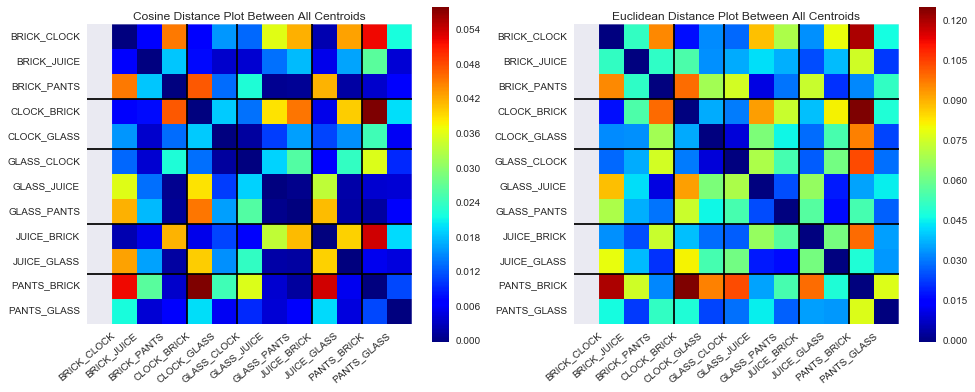

In [10]:
# Now for each match feature, compute centroid and compute distances from all centroids pairwise
matches = match_features.keys()
centroids_dict = {}

# loop through all match/probes
for match in matches:
    centroid = np.mean(match_features[match], axis=0)
    centroids_dict[match] = centroid
    
## Resort the centroids based on probeword
centroids = []
sortkeys = sorted(centroids_dict.keys())
for key in sortkeys:
    centroids.append(centroids_dict[key])
    
centroids = np.array(centroids)

# compute distance matrix
distances = scipy.spatial.distance.pdist(centroids, metric='cosine')
distances = scipy.spatial.distance.squareform(distances)

# Plot the distances matrix
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Cosine Distance Plot Between All Centroids")
plt.yticks(np.arange(0,12, 1), sortkeys)
plt.xticks(np.arange(-1.5,12-1.5, 1), sortkeys, rotation='40')
ax = plt.gca()
yline = [2.5, 4.5, 7.5, 9.5]
for i in range(0, len(yline)):
    plt.axhline(y=yline[i], color='k')
    plt.axvline(x=yline[i], color='k')
ax.grid(False)
plt.colorbar()

# compute distance matrix
distances = scipy.spatial.distance.pdist(centroids, metric='euclidean')
distances = scipy.spatial.distance.squareform(distances)

plt.subplot(122)
plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Euclidean Distance Plot Between All Centroids")
plt.yticks(np.arange(0,12, 1), sortkeys)
plt.xticks(np.arange(-1.5,12-1.5, 1), sortkeys, rotation='40')
ax = plt.gca()
xmin = ax.get_xlim

yline = [2.5, 4.5, 7.5, 9.5]
for i in range(0, len(yline)):
    plt.axhline(y=yline[i], color='k')
    plt.axvline(x=yline[i], color='k')
ax.grid(False)
plt.colorbar()

print "An example of a feature centroid: \n", centroids[0]

## Discussion of Distance Matrix Analyzing Distinct ProbeWords with Target Words
Here is a distance matrix between all the "centroids" (7x1 feature vector of all 7 frequency bins) for both. The range of distances is 0 - 0.006 for cosine distances and 0 - 0.03 for euclidean distance. I plotted lines to distinguish groups with the same starting probe word.

It is interesting that GLASS/PANTS & PANTS/GLASS show some sort of difference with respect to cosine space, but the difference is not very large. However, relative to the other word pairs, it seems to have rotational distances of at least twice as much (cosine is a rotation with respect to origin). 

The euclidean distance plot is hard to see any trends; not much to show in the network plot.

What I want to do next is to the look at the spread of data points going into each centroid. How are these spread?

In [208]:
## Drawing distance plot as a network
# import networkx as nx
# G=nx.from_numpy_matrix(distances)
# plt.subplot(211)
# nx.draw(G, edge_color = [ i[2]['weight'] for i in G.edges(data=True) ], edge_cmap=matplotlib.cm.winter )

# import networkx as nx
# import numpy as np
# import string

# DistMatrix = np.array([
#         [0,      1,    0.4,    0.7],
#         [1,    0,      0.9,    0.2],
#         [0.4,    0.9,    0,      0.1],
#         [0.7,    0.2,    0.1,    0] 
# ])
    
# import networkx as nx
# G = nx.from_numpy_matrix(DistMatrix)
# nx.draw(G)

In [11]:
print match_features.keys()
print match_features[pair].shape

juice_matches = {}
brick_matches = {}
clock_matches = {}
pants_matches = {}
glass_matches = {}

fig = plt.figure()
for match in match_features.keys():
    if match[0:5] == 'JUICE':
        juice_matches[match] = match_features[match]
    elif match[0:5] == 'BRICK':
        brick_matches[match] = match_features[match]
    elif match[0:5] == 'CLOCK':
        clock_matches[match] = match_features[match]
    elif match[0:5] == 'PANTS':
        pants_matches[match] = match_features[match]
    elif match[0:5] == 'GLASS':
        glass_matches[match] = match_features[match]

# juice_matches = np.array(juice_matches)
print juice_matches.keys()
print glass_matches.keys()

['JUICE_GLASS', 'BRICK_JUICE', 'CLOCK_GLASS', 'GLASS_CLOCK', 'GLASS_JUICE', 'BRICK_CLOCK', 'GLASS_PANTS', 'PANTS_BRICK', 'PANTS_GLASS', 'JUICE_BRICK', 'BRICK_PANTS', 'CLOCK_BRICK']
(96, 7)
['JUICE_BRICK', 'JUICE_GLASS']
['GLASS_CLOCK', 'GLASS_JUICE', 'GLASS_PANTS']


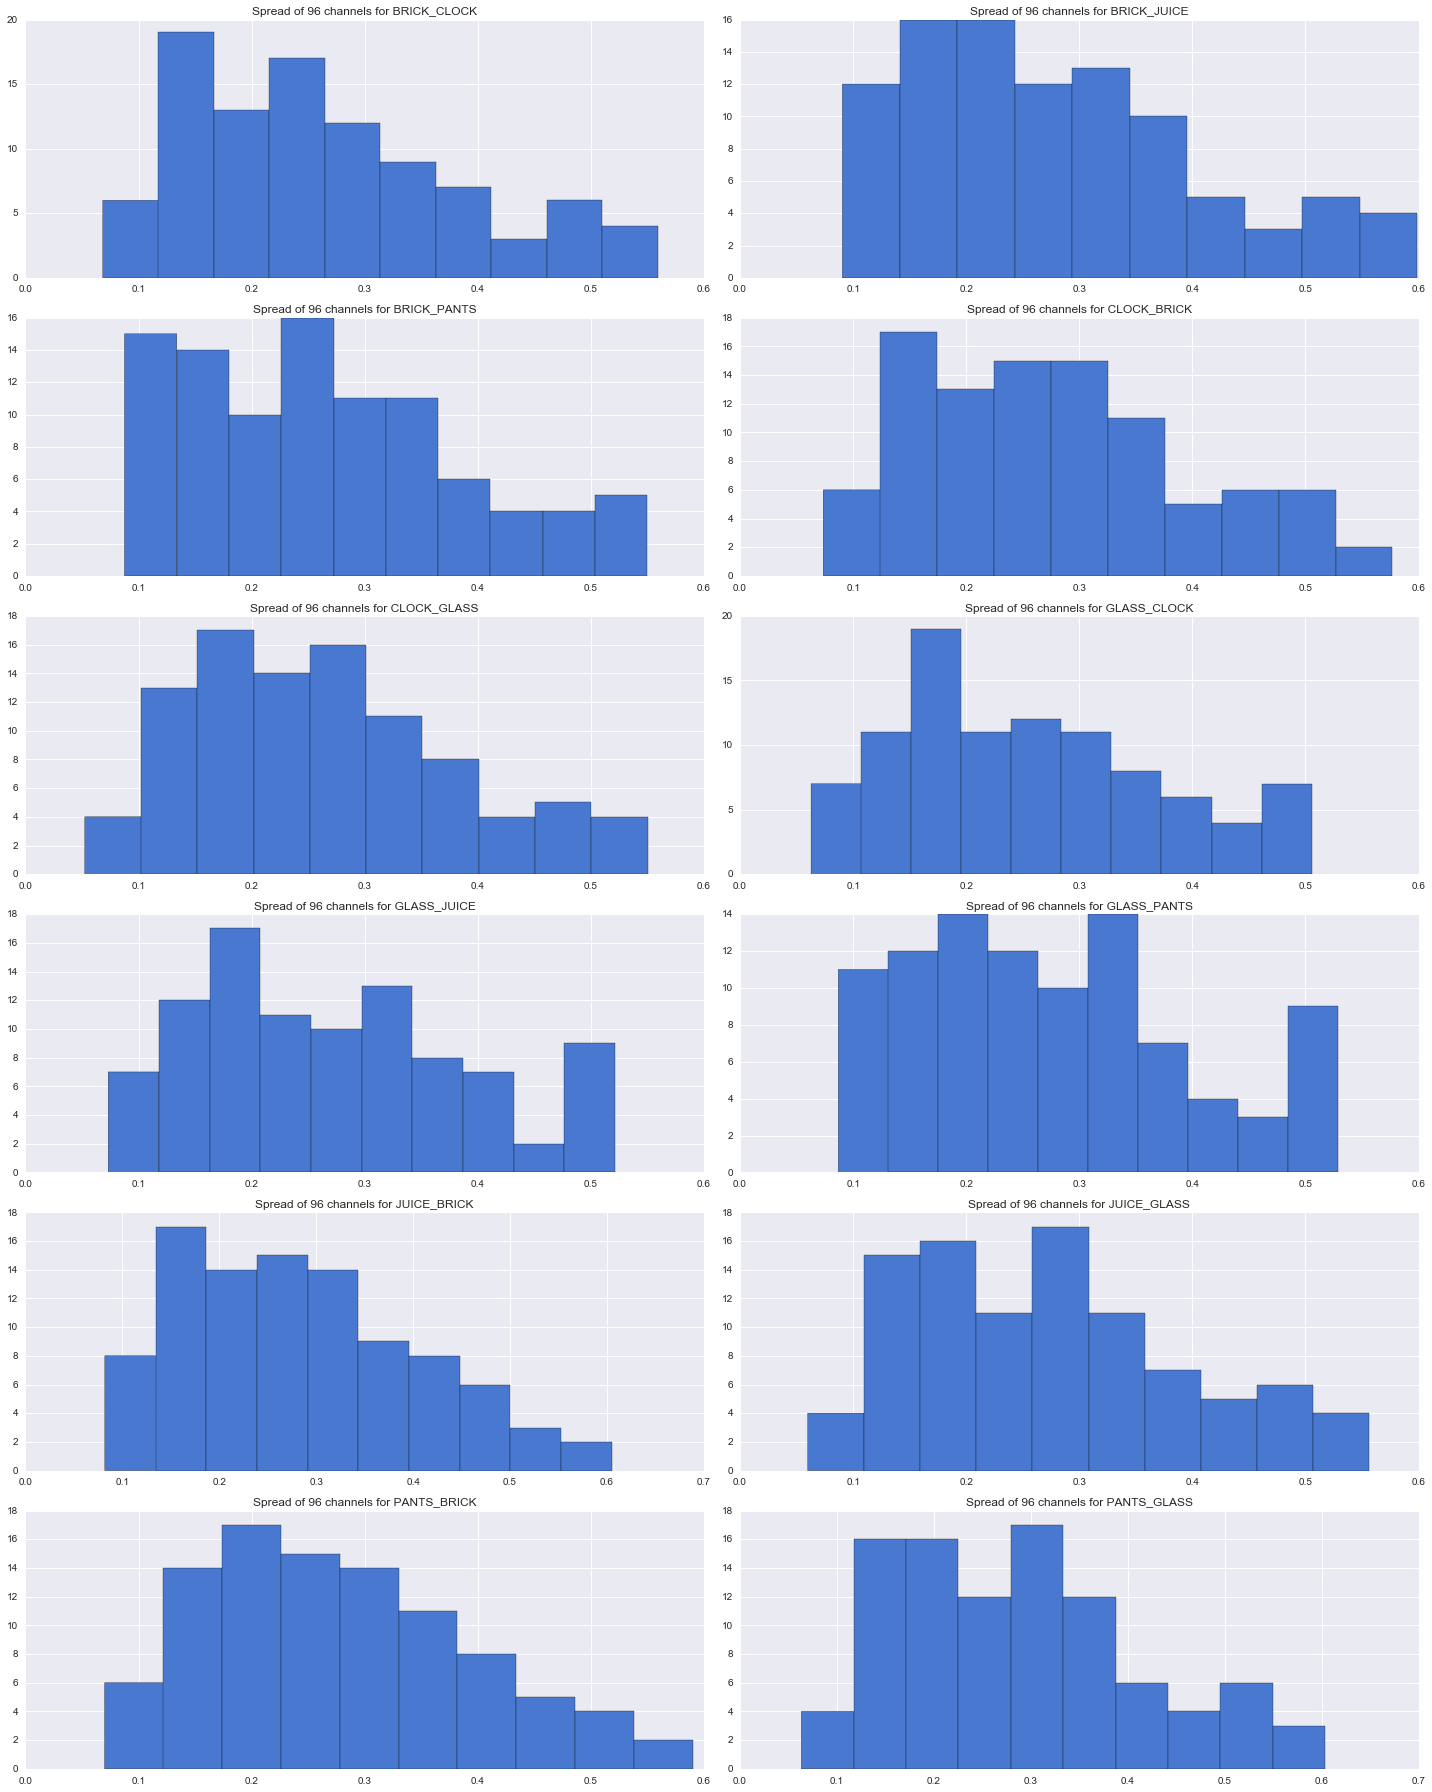

In [179]:
# look at match_features again
# look at spread of 96 channels for each word pair of interest

sortkeys = sorted(centroids_dict.keys())
fig=plt.figure(figsize=(20,25))
for idx, key in enumerate(sortkeys):
    features = match_features[key]
    
    norm_match = np.linalg.norm(features, axis=1)

    plt.subplot(len(sortkeys)/2, 2, idx+1)
    plt.hist(norm_match)
    plt.title("Spread of 96 channels for "+key)
plt.tight_layout()

## Discussion of Spread of Values For Each Word Match/Pair
Here each unique word match pair (n=12) has 96 channels that feed in a 7x1 frequency bin vector. The distribution shows what each of these 96 channels are measuring on average over the time period (probeWordOn - vocalization =~ 1-3 seconds usually).

In order to compare the average of these histograms (the centroid values), then it would require these histograms to have a generally normal distribution, else outliers can easily skew the averages. 

## Work To Continue
In order to improve analyses, I was thinking of looking at a couple of things:
1. A 500 ms window of evolving brain state (e.g. 7x1 feature vector) for all channels for a certain word pair match vs. another one vs. a similar word. For example BRICK/GLASS vs. BRICK/PANTS vs. JUICE/PANTS.
2. Channel-wide ANOVA done on all frequency/time bins for each word match pair 
3. Working on getting cluster statistic working for within subject analysis of all channels

To Do:
First: For every 1431 events -> divide into the 12 groups (not averaging across events) -> word pair A, where does it lie in the 96,7 dimensional space (concatenating instead of averaging across channels)

Second: Electrode 
raw data = channels and frequency bands identify first n PC for each wordpair and then compute distance

Third: ANOVA to reduce dimensionality

later: averaging later, and compare distributions instead of the electrodes between 

The array of centroids we have are of shape:  (12, 672)


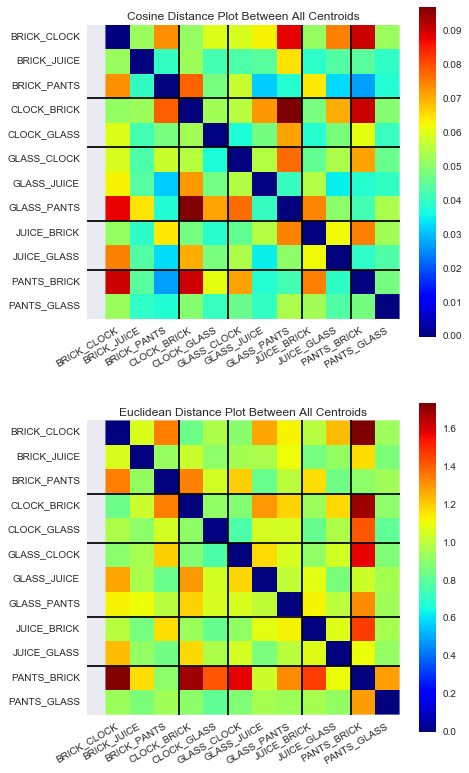

In [12]:
###################### GET ALL CENTROIDS WITHOUT AVERAGING ACROSS CHANNELS ####################
# Now for each match feature, compute centroid and compute distances from all centroids pairwise
matches = match_features.keys()
centroids_dict = {}

# loop through all match/probes
for match in matches:
#     print match
#     print match_features[match].shape
    centroid = np.ndarray.flatten(match_features[match])
    centroids_dict[match] = centroid

# Resort the centroids based on probeword
centroids = []
sortkeys = sorted(centroids_dict.keys())
for key in sortkeys:
    centroids.append(centroids_dict[key])
    
centroids = np.array(centroids)
print "The array of centroids we have are of shape: ", centroids.shape
########### centroids is an array of the 12 unique trigger types X dimensional feature ###########

# compute distance matrix
distances = scipy.spatial.distance.pdist(centroids, metric='cosine')
distances = scipy.spatial.distance.squareform(distances)

# Plot the distances matrix
fig = plt.figure(figsize=(7,13))
plt.subplot(211)
plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Cosine Distance Plot Between All Centroids")
plt.yticks(np.arange(0,12, 1), sortkeys)
plt.xticks(np.arange(-1.25,12-1.25, 1), sortkeys, rotation='30')
ax = plt.gca()
yline = [2.5, 4.5, 7.5, 9.5]
for i in range(0, len(yline)):
    plt.axhline(y=yline[i], color='k')
    plt.axvline(x=yline[i], color='k')
ax.grid(False)
plt.colorbar()

# compute distance matrix
distances = scipy.spatial.distance.pdist(centroids, metric='euclidean')
distances = scipy.spatial.distance.squareform(distances)

plt.subplot(212)
plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Euclidean Distance Plot Between All Centroids")
plt.yticks(np.arange(0,12, 1), sortkeys)
plt.xticks(np.arange(-1.25,12-1.25, 1), sortkeys, rotation='30')
ax = plt.gca()
xmin = ax.get_xlim

yline = [2.5, 4.5, 7.5, 9.5]
for i in range(0, len(yline)):
    plt.axhline(y=yline[i], color='k')
    plt.axvline(x=yline[i], color='k')
ax.grid(False)
plt.colorbar()
# font = {
#         'size'   : 10}

# matplotlib.rc('font', **font)
# print "An example of a feature centroid: \n", centroids[0]

## PCA Analysis


0.98487785974
The array of centroids we have are of shape:  (12, 10)


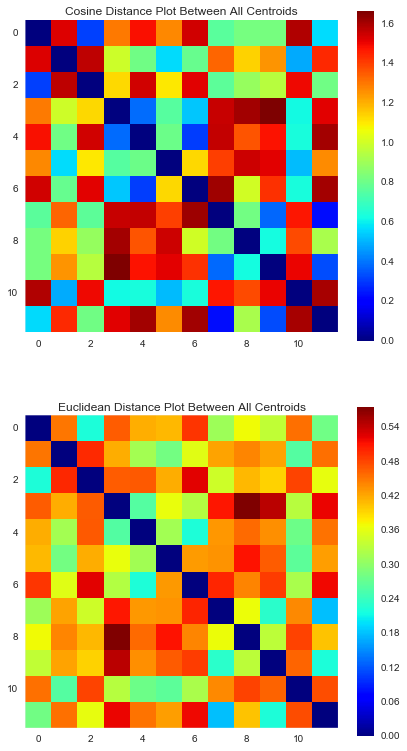

In [30]:
pca = PCA(n_components=10)
matches = match_features.keys()
centroids_dict = {}

# loop through all match/probes
new_match_features = []
for match in matches:
    new_match_features.append(np.ndarray.flatten(match_features[match]))

new_match_features = np.array(new_match_features)

## perform pca on the 12x672 matrix
pca_centroids = pca.fit_transform(new_match_features)
print sum(pca.explained_variance_ratio_)

centroids = np.array(pca_centroids)
print "The array of centroids we have are of shape: ", centroids.shape
########### centroids is an array of the 12 unique trigger types X dimensional feature ###########

# compute distance matrix
distances = scipy.spatial.distance.pdist(centroids, metric='cosine')
distances = scipy.spatial.distance.squareform(distances)

# Plot the distances matrix
fig = plt.figure(figsize=(7,13))
plt.subplot(211)
plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Cosine Distance Plot Between All Centroids")
ax = plt.gca()
ax.grid(False)
plt.colorbar()

# compute distance matrix
distances = scipy.spatial.distance.pdist(centroids, metric='euclidean')
distances = scipy.spatial.distance.squareform(distances)

plt.subplot(212)
plt.imshow(distances, cmap=plt.get_cmap('jet'), interpolation='none')
plt.title("Euclidean Distance Plot Between All Centroids")
ax = plt.gca()
xmin = ax.get_xlim

ax.grid(False)
plt.colorbar()